# 🔀 Comparación de Algoritmos de Clustering

Este notebook tiene como objetivo **comparar visualmente distintos algoritmos de clustering** aplicados sobre el mismo dataset.  
De esta manera, se pueden observar sus diferencias en la forma en que agrupan los datos.

---

## 🚀 Algoritmos evaluados
- **K-Means** → basado en centroides.  
- **Agglomerative (Jerárquico)** → agrupamiento por fusiones sucesivas.  
- **DBSCAN** → clustering basado en densidad, detecta outliers.  
- **Birch** → eficiente con grandes volúmenes de datos.  

---

## 📊 Metodología
1. Se genera un dataset de prueba (o se utiliza uno real).  
2. Se entrenan distintos algoritmos de clustering con parámetros iniciales.  
3. Se visualizan los resultados en subplots comparativos.  

---

## 🖼️ Visualización
Cada gráfico muestra:  
- Los **puntos coloreados según el clúster asignado**.  
- Los **ruidos/outliers** en caso de DBSCAN.  
- La forma particular de agrupación que produce cada algoritmo.  

---

## ✅ Conclusiones
- Los algoritmos de clustering no siempre producen los mismos resultados.  
- La elección depende de:
  - La **naturaleza de los datos** (esféricos, densidades variadas, presencia de ruido).  
  - Los **objetivos del análisis** (interpretabilidad vs. escalabilidad).  
- Comparar visualmente ayuda a entender qué método es más adecuado para el problema.  


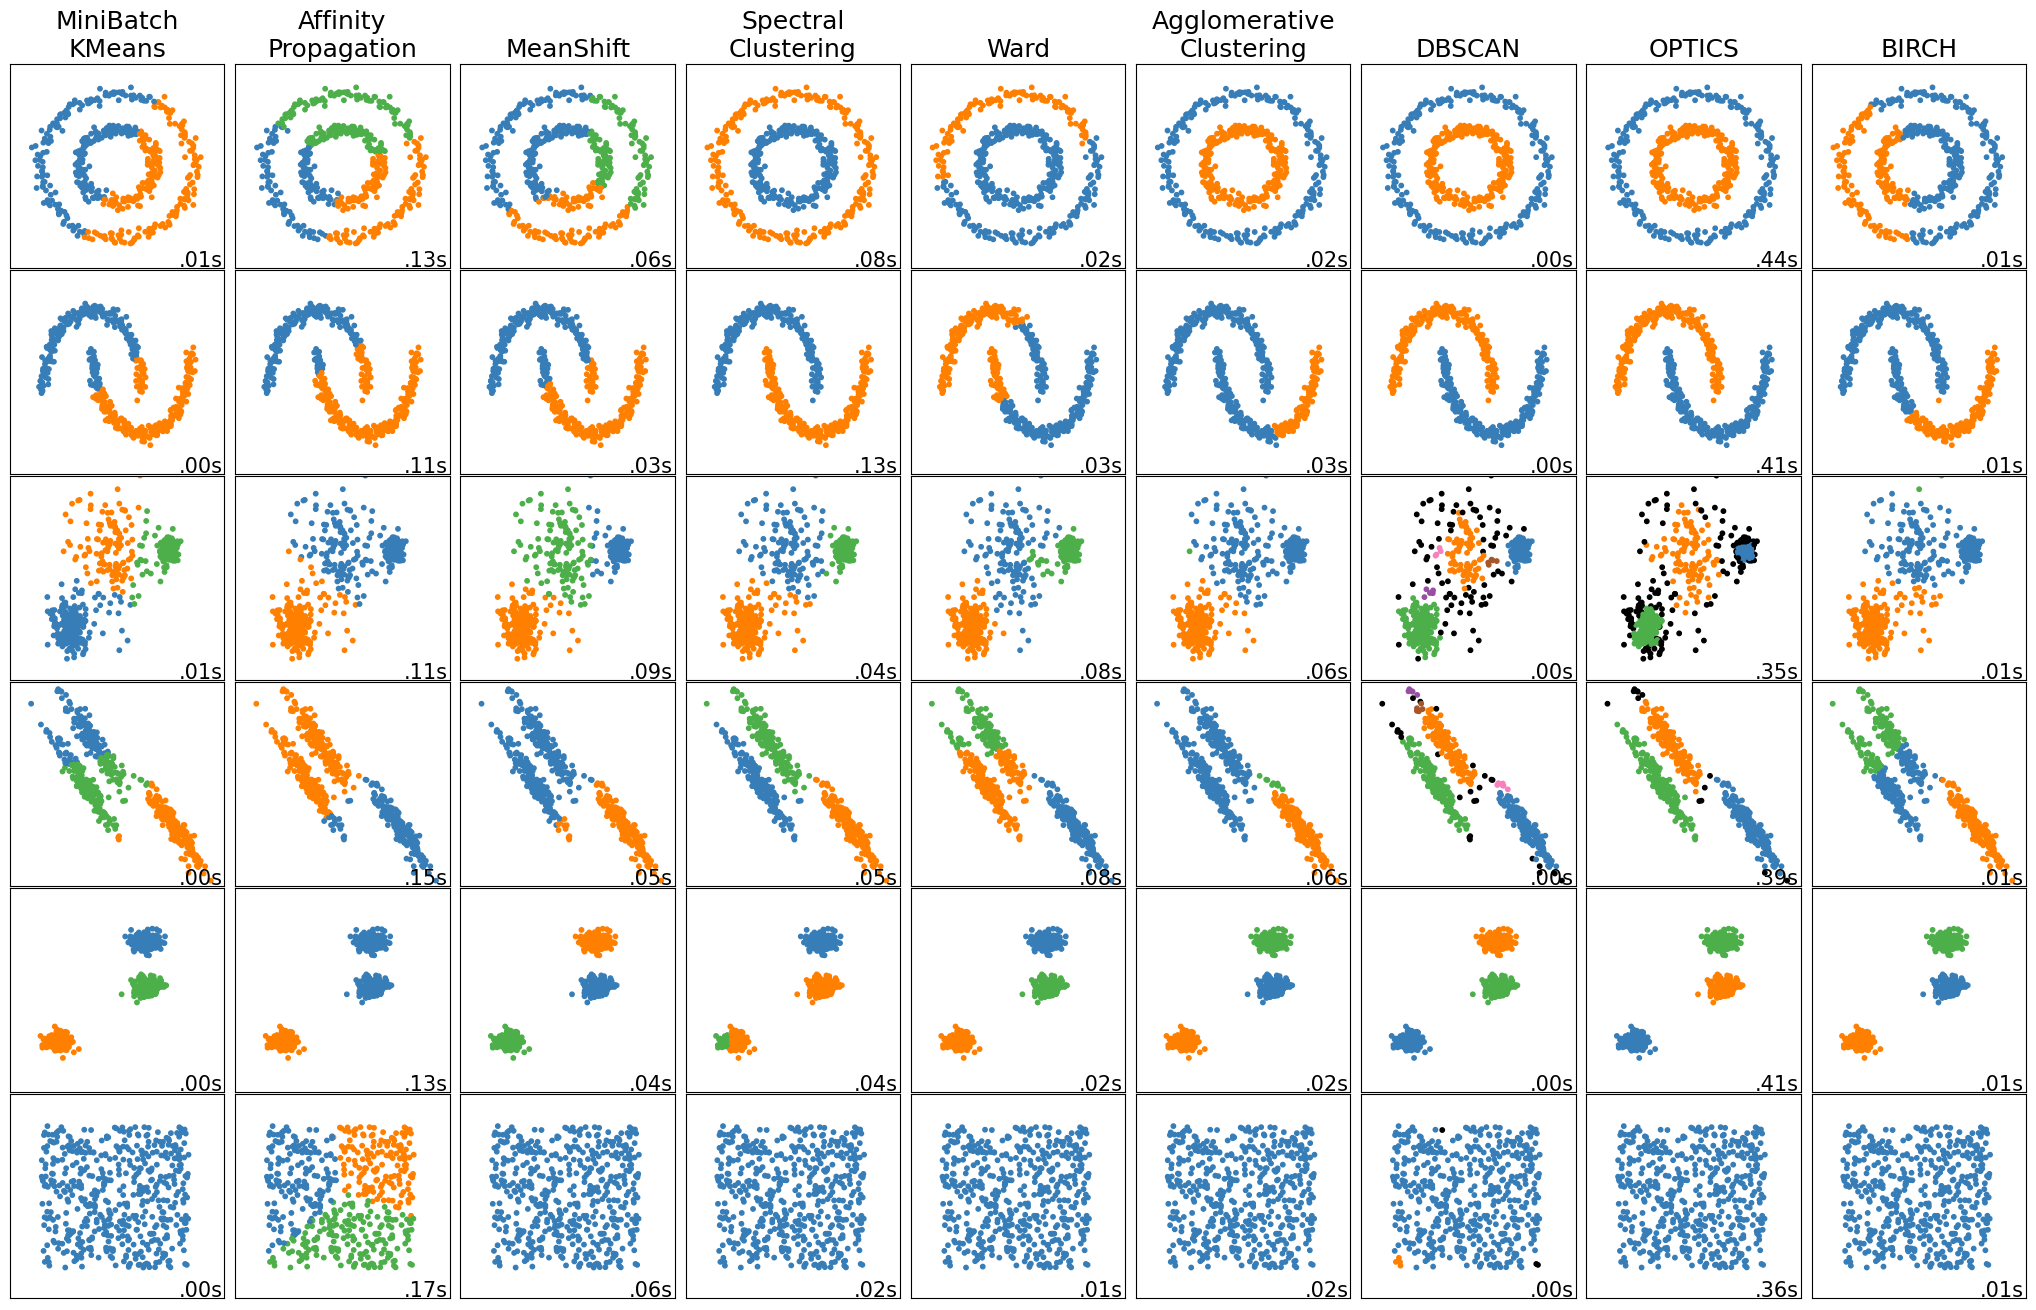

In [ ]:
# Fuente: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
# más info: https://scikit-learn.org/stable/modules/clustering.html

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets   #, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============================================================
# 📘 ¿Por qué se hace esto?
# En la práctica, cuando estudiamos clustering (K-Means, DBSCAN, Jerárquico, etc.) necesitamos datasets con características 
# bien distintas para ver en qué casos cada algoritmo funciona mejor o peor.
# Entonces se generan ejemplos artificiales con formas específicas:
# ============================================================

# ============================================================
# Dataset 1: círculos concéntricos con ruido
# Sirven para probar si el algoritmo puede detectar clusters que no son lineales.
# 👉 K-Means falla porque solo arma clusters esféricos.
# 👉 DBSCAN o Spectral Clustering lo resuelven bien.

noisy_circles = datasets.make_circles(n_samples=500, factor=0.5, noise=0.05)
# ============================================================

# ============================================================
# Dataset 2: lunas crecientes con ruido
# Dos formas de media luna entrelazadas.
# Ejemplo típico de clusters curvos y no convexos.
# 👉 Excelente para mostrar que K-Means no sirve en formas complejas, pero DBSCAN sí.
# 👉 Muestra cuándo DBSCAN brilla.

noisy_moons = datasets.make_moons(n_samples=500, noise=0.05)
# ============================================================

# ============================================================
# Dataset 3: blobs (clusters gaussianos esféricos)
# Grupos gaussianos esféricos, el caso “ideal” para K-Means.
# 👉 Muestra cuándo K-Means brilla.

blobs = datasets.make_blobs(n_samples=500, random_state=8)
# ============================================================

# ============================================================
# Dataset 4: nube de puntos sin estructura
# Nube aleatoria sin clusters reales.
# 👉 Sirve para comprobar si el algoritmo es capaz de no inventar clusters donde no hay.

no_structure = np.random.rand(n_samples, 2), None
# ============================================================


# ✅ Conclusión

# Se hace esto para tener un banco de pruebas controlado:
# Ver cómo se comportan los algoritmos en distintos escenarios de datos.
# Identificar fortalezas y limitaciones de cada técnica.
# Usar gráficos comparativos para aprender qué algoritmo elegir en un problema real.


# ============================================================
# Dataset 5: datos anisotrópicos (alargados por transformación lineal)
# sirven para ver qué pasa con clusters alargados y rotados.
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
# ============================================================


# Dataset 6: blobs con distinta varianza
# sirven para ver qué pasa cuando los clusters tienen tamaños y densidades muy diferentes.
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
# ============================================================


# ============================================================
# Set up cluster parameters
# ============================================================
plt.figure(figsize=(9 * 2 + 3, 13))  # tamaño del gráfico global
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95,
                    wspace=0.05, hspace=0.01)

plot_num = 1  # contador para subplots

# Parámetros por defecto para los algoritmos
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {'n_clusters': 1}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # Copiamos parámetros base y actualizamos con específicos del dataset
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # Normalizamos el dataset (media=0, var=1)
    # Se aplica normalización estándar a los datos.
    # Cada característica queda con media = 0 y desviación estándar = 1.
    X = StandardScaler().fit_transform(X)

    # Estimamos ancho de banda para MeanShift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # Matriz de conectividad para Ward
    connectivity = kneighbors_graph(X, n_neighbors=params["n_neighbors"], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)  # simetrizamos
    # ============================================================================================================
    # ✅ En resumen:
    # Este bloque prepara cada dataset antes de aplicarle los algoritmos de clustering:
    # Toma sus parámetros específicos.
    # Normaliza las variables.
    # Calcula bandwidth para MeanShift.
    # Construye una matriz de conectividad para algoritmos jerárquicos.
    # ============================================================================================================

    # ============
    # Create cluster objects
    # ============

    # MeanShift
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    # MiniBatch K-Means
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        n_init="auto"
    )

    # Agglomerative (Ward)
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"],
        linkage="ward",
        connectivity=connectivity
    )

    # Spectral Clustering
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors"
    )

    # DBSCAN
    dbscan = cluster.DBSCAN(eps=params["eps"])

    # OPTICS
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"]
    )

    # Affinity Propagation
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=0
    )

    # Agglomerative (Average Linkage)
    average_linkage = cluster.AgglomerativeClustering(
        metric="manhattan",
        linkage="average",
        n_clusters=params["n_clusters"],
        connectivity=connectivity
    )

    # Birch
    birch = cluster.Birch(n_clusters=params["n_clusters"])


    # ✅ En resumen:
    # Ese bloque prepara una batería de algoritmos de clustering diferentes (basados en centroides, jerarquía, grafos, densidad, mensajes, árboles) para que después puedas compararlos en los mismos datasets y ver en qué escenarios funciona mejor cada uno.

    #gmm = mixture.GaussianMixture(
    #    n_components=params["n_clusters"], covariance_type="full")

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        #("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()   # medir tiempo de ejecución

        # Ignorar warnings de conectividad
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",
                message="the number of connected components ...", category=UserWarning)
            warnings.filterwarnings("ignore",
                message="Graph is not fully connected...", category=UserWarning)
            algorithm.fit(X)   # entrenar modelo

        t1 = time.time()

        # Obtener etiquetas de cluster
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        # DISEñO
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

Lo que estás viendo es un experimento comparativo de algoritmos de clustering sobre varios datasets sintéticos.
La idea es mostrar cómo se comporta cada algoritmo en diferentes formas de datos.

📘 Cómo leer la imagen

Columnas → cada una es un algoritmo de clustering:

Filas → cada una es un dataset de prueba:

Colores → representan los clusters detectados por cada algoritmo.

Tiempo (ej: .02s) → cuánto tardó el algoritmo en ejecutarse.

📊 Interpretación por dataset

Círculos concéntricos

KMeans, Ward, Agglomerative, Birch fallan (cortan los círculos).

Spectral Clustering y DBSCAN aciertan (detectan bien los anillos).

OPTICS también lo logra aunque más lento.

Lunas crecientes

Igual que antes: KMeans y jerárquicos dividen mal.

DBSCAN, OPTICS y Spectral Clustering separan perfectamente las dos lunas.

Blobs con distinta varianza

KMeans separa mal (divide un cluster disperso en varios).

DBSCAN y OPTICS funcionan bien.

Ward/Agglomerative hacen un trabajo decente.

Datos anisotrópicos (alargados)

KMeans falla (corta clusters en diagonal).

Jerárquicos y DBSCAN lo hacen mucho mejor.

Spectral también detecta bien la estructura.

Blobs gaussianos esféricos

Todos los algoritmos funcionan bien.

Caso ideal para KMeans.

Nube aleatoria (sin estructura)

Los algoritmos “inteligentes” (DBSCAN, OPTICS) tienden a dejar un solo cluster (correcto).

Otros (Affinity, Spectral, etc.) fuerzan clusters inexistentes.

✅ Conclusiones clave

KMeans y Birch → buenos cuando los clusters son redondos, del mismo tamaño y dispersión.

Jerárquicos (Ward, Average) → mejores en datos alargados o con estructuras claras.

DBSCAN y OPTICS → sobresalen cuando los clusters tienen formas raras o densidades distintas, y además detectan ruido.

Spectral Clustering → excelente para estructuras no lineales como círculos y lunas.

Affinity Propagation → a veces inventa clusters donde no debería (ej. nube aleatoria).

MeanShift → se adapta bien a densidades, pero puede ser más lento.